## Input: Bộ dữ liệu gồm các tham số đầu vào: lon, lat: kinh độ, vĩ độ và rainfall là lượng mưa tương ứng
## Output: Mảng chứa các giá trị rainfall được nội suy trên các điểm của lưới

### Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'rainfall_data.xls'  
df = pd.read_excel(file_path)

rainfall_data = df['rainfall'].to_numpy()
lat = df['lat'].to_numpy()
lon = df['lon'].to_numpy()

grid_size = (6, 8)

### Các điểm dữ liệu mẫu trên đồ thị 2D và 3D

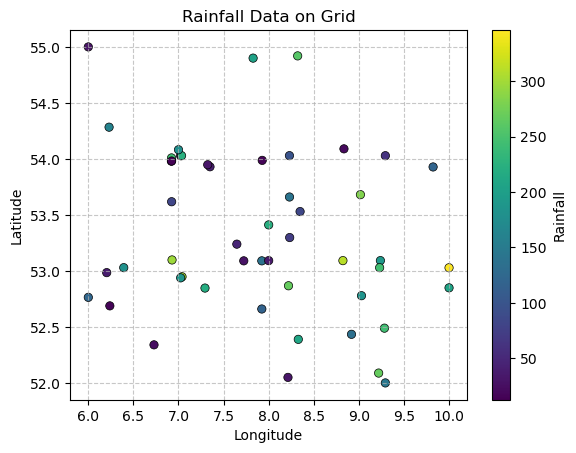

In [2]:
grid = np.zeros(grid_size)

plt.scatter(lon, lat, c=rainfall_data, cmap='viridis', marker='o', edgecolors='black', linewidth=0.5)
plt.colorbar(label='Rainfall')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rainfall Data on Grid')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

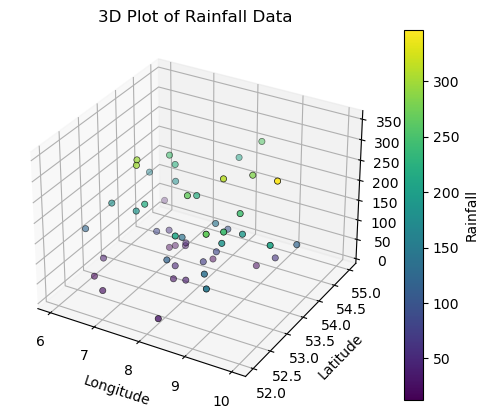

In [3]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(lon, lat, rainfall_data, c=rainfall_data, cmap='viridis', marker='o', edgecolors='black', linewidth=0.5)
cbar = plt.colorbar(sc, ax=ax, label='Rainfall')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Rainfall')
ax.set_title('3D Plot of Rainfall Data')

# Hiển thị đồ thị
plt.show()

## NỘI SUY LÁNG GIỀNG GẦN

### Hàm nội suy 

In [4]:
def nearest_neighbor_interpolation_2d(x, y, v, X, Y):
    interpolated_values = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Tìm điểm dữ liệu gần nhất
            idx = np.argmin((x - X[i, j])**2 + (y - Y[i, j])**2)
            
            # Gán giá trị nội suy
            interpolated_values[i, j] = v[idx]
    
    return interpolated_values


In [5]:
new_lat, new_lon = np.mgrid[52:55:100j, 6:10:100j]

interpolated_rainfall = nearest_neighbor_interpolation_2d(lat, lon, rainfall_data, new_lat, new_lon)

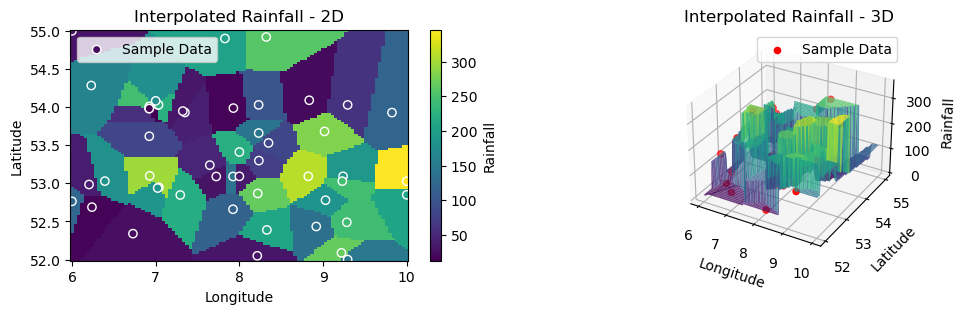

In [6]:
plt.figure(figsize=(12, 3))

# Đồ thị 2D
plt.subplot(121)
plt.pcolormesh(new_lon, new_lat,  interpolated_rainfall, shading='auto', cmap='viridis')
plt.scatter(lon, lat,  c=rainfall_data, cmap='viridis', edgecolors='w', linewidth=1, marker='o', label='Sample Data')
plt.colorbar(label='Rainfall')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Rainfall - 2D')
plt.legend()

# Đồ thị 3D
ax = plt.subplot(122, projection='3d')
ax.plot_surface(new_lon, new_lat, interpolated_rainfall, cmap='viridis', alpha=0.8)
ax.scatter(lon, lat, rainfall_data, c='red', marker='o', label='Sample Data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Rainfall')
ax.set_title('Interpolated Rainfall - 3D')
ax.legend()

plt.show()

## NỘI SUY TUYẾN TÍNH 2 CHIỀU (BILINEAR INTERPOLATION)

In [7]:
rainfall_data = df.to_numpy()
grid_size = (6, 8)
num_rows = 100
num_cols = 100

column_names = ['rainfall', 'lat', 'lon']

# Tạo DataFrame từ array
df = pd.DataFrame(rainfall_data, columns=column_names)

### Hàm T^-1

In [8]:
def norm(vector):
    return np.sqrt(np.sum(vector**2))

def inverse_transform(p, p1, p2, p3):
    return (norm(np.cross(p - p1, p3 - p1)) / norm(np.cross(p2 - p1, p3 - p1))), (norm(np.cross(p - p1, p2 - p1)) / norm(np.cross(p3 - p1, p2 - p1)))


### Hàm tìm tọa độ và giá trị 3 điểm gần với điểm cần nội suy (triangle cell)

In [9]:
def find_nearest_coordinates(df, input_lon, input_lat, num_points=3):
    # Tạo một điểm cần nội suy
    input_point = np.array([input_lon, input_lat])
    
    # Tính khoảng cách từ điểm đến tất cả các điểm trong DataFrame
    df['distance'] = np.linalg.norm(df[['lon', 'lat']].values - input_point, axis=1)
    
    # Chọn ra num_points điểm gần nhất
    nearest_points = df.nsmallest(num_points, 'distance')
    
    # Lưu tọa độ của 3 điểm gần nhất vào 3 mảng
    points_array = nearest_points[['lon', 'lat']].values
    
    # Trả về 3 mảng chứa tọa độ của 3 điểm gần nhất
    values = nearest_points[['rainfall']].values
    
    return points_array, values


### Hàm chuyển tọa độ thế giới sang tọa độ tham chiếu

In [10]:
def convert(df, input_lon, input_lat):
    nearest_points, _ = find_nearest_coordinates(df, input_lon, input_lat)
    v1, v2, v3 = nearest_points
    P = np.array([input_lon, input_lat])

    r, s = inverse_transform(P, v1, v2, v3)
    return r, s


### Hàm trọng số Phi

In [11]:
def Phi_function(df, input_lon, input_lat):
    r,s = convert(df, input_lon, input_lat)
    Phi1 = 1-r-s
    Phi2 = r
    Phi3 = s 
    Phi = np.array([Phi1, Phi2, Phi3])
    return Phi

### Tạo lưới với các điểm dữ liệu mới và áp dụng nội suy tuyến tính 

In [12]:
lon_new = np.linspace(6, 10, num_cols)
lat_new = np.linspace(52, 55, num_rows)

Z_approximated = np.zeros((num_rows, num_cols), dtype=float)

for i in range(num_rows):
    for j in range(num_cols):
        Phi = Phi_function(df, lon_new[i], lat_new[j])
        nearest_points, data = find_nearest_coordinates(df, lon_new[i], lat_new[j])
        Z_approximated[i, j] = np.sum(Phi * data)


/var/folders/hk/c9c4mlq57ns0qq7d4n_m9y480000gn/T/ipykernel_2468/1058737813.py:6: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = axs[0].scatter(df['lon'], df['lat'], c=df['rainfall'], cmap='viridis', marker='x', edgecolors='r', linewidths=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


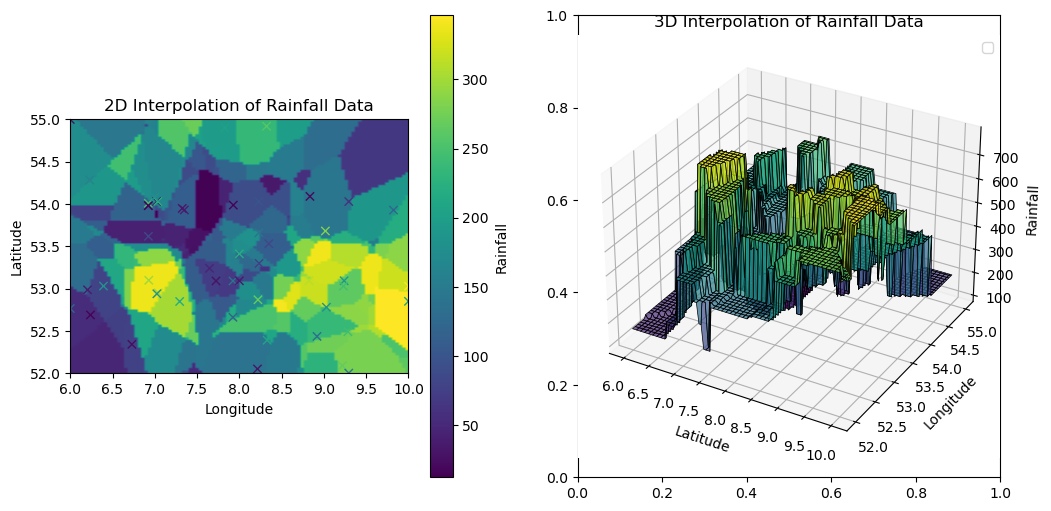

In [ ]:

# Trực quan hóa dữ liệu nội suy trên đồ thị 2D và 3D trên cùng 1 biểu đồ
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Đồ thị 2D
axs[0].imshow(Z_approximated.T, origin='lower', extent=(lon_new.min(), lon_new.max(), lat_new.min(), lat_new.max()))
sc = axs[0].scatter(df['lon'], df['lat'], c=df['rainfall'], cmap='viridis', marker='x', edgecolors='r', linewidths=1)
axs[0].set_title('2D Interpolation of Rainfall Data')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
fig.colorbar(sc, ax=axs[0], label='Rainfall')

# Đồ thị 3D
axs[1] = fig.add_subplot(122, projection='3d')
lon_grid, lat_grid = np.meshgrid(lon_new, lat_new)
surf = axs[1].plot_surface(lon_grid, lat_grid, Z_approximated.T, cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)
axs[1].set_ylabel('Longitude')
axs[1].set_xlabel('Latitude')
axs[1].set_zlabel('Rainfall')
axs[1].set_title('3D Interpolation of Rainfall Data')
axs[1].legend()


plt.show()